In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder, LabelBinarizer


import warnings

warnings.filterwarnings(
    action="ignore",
    category=FutureWarning,
    module='seaborn',
)

In [2]:
sample_submission_filepath = '/kaggle/input/spaceship-titanic/sample_submission.csv'
train_filepath, test_filepath = '/kaggle/input/spaceship-titanic/train.csv', '/kaggle/input/spaceship-titanic/test.csv'

# Inspecting the Dataset

In [3]:
sample_sub = pd.read_csv(sample_submission_filepath)
raw_test_data = pd.read_csv(test_filepath)
raw_train_data = pd.read_csv(train_filepath)
sample_sub.head()

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False


In [4]:
raw_train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
raw_train_data.describe(include = 'object')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
count,8693,8492,8476,8494,8511,8490,8493
unique,8693,3,2,6560,3,2,8473
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,False,Gollux Reedall
freq,1,4602,5439,8,5915,8291,2


In [6]:
raw_train_data.describe(include = 'number')

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
graphing_data = raw_train_data.copy()
bills = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
graphing_data['TotalBill'] = graphing_data[bills].sum(axis = 1)
graphing_data['NoBills'] = graphing_data['TotalBill'] == 0

### Initial Data Visualisation

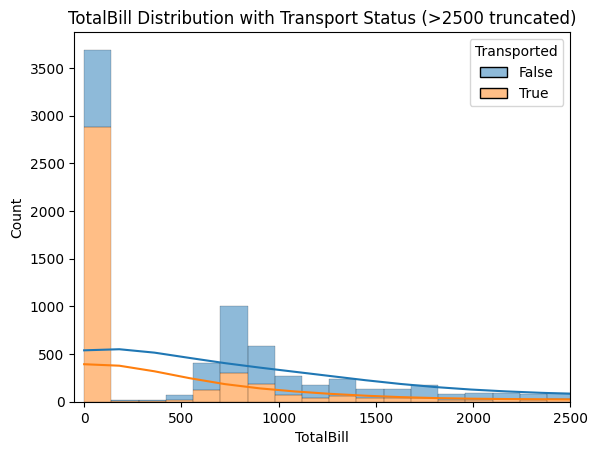

In [8]:
#fig = plt.figure(figsize = (20, 6))
plt.title('TotalBill Distribution with Transport Status (>2500 truncated)')
sns.histplot(data = graphing_data, x = 'TotalBill', hue = 'Transported', multiple = 'stack', kde = True)
plt.xlim([-50, 2500])
plt.show()

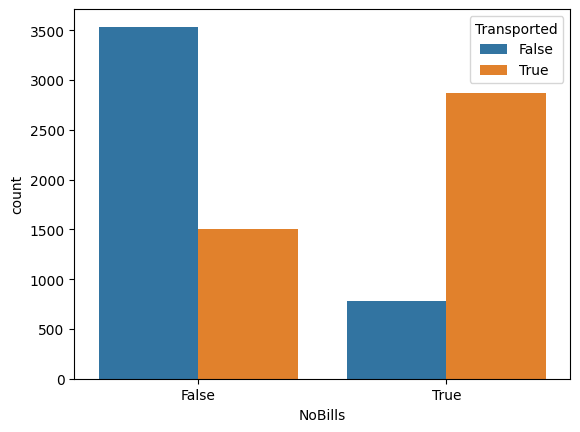

In [9]:
sns.countplot(data = graphing_data, x = 'NoBills', hue = 'Transported')
plt.show()

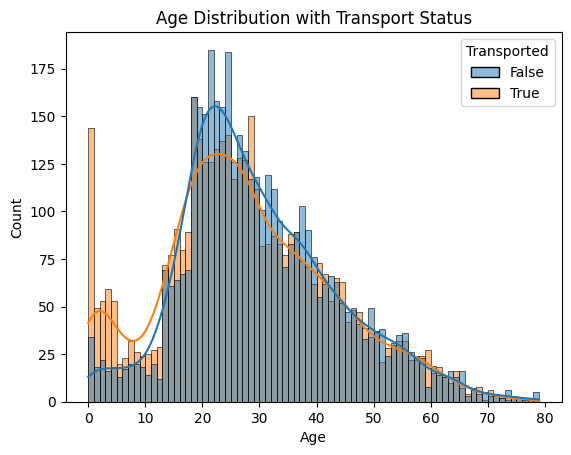

In [10]:
#fig = plt.figure(figsize = (20, 6))
plt.title('Age Distribution with Transport Status')
sns.histplot(data=graphing_data, x='Age', hue='Transported', binwidth=1, kde=True)
plt.show()

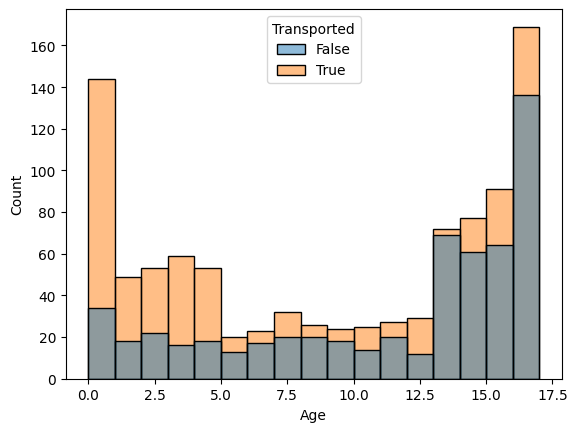

In [11]:
sns.histplot(data=graphing_data[graphing_data['Age'] < 18], x = 'Age', hue='Transported', binwidth = 1)
plt.show()

# PREPROCESSING

### Unpacker functions
* Used to unpack certain columns into new ones
* Group size calculation function is also defined here

In [12]:
class UnpackData:
    def __init__(self, new_cols, delimiter):
        #self.col_name = col_name
        self.new_cols = new_cols
        self.delimiter = delimiter       

def SeriesUnpack(data):
    col_names = unpack_dict[data.name].new_cols
    col_names = dict(enumerate(col_names))
    delimiter = unpack_dict[data.name].delimiter
    return data.str.split(delimiter, expand = True).rename(columns = col_names)

def Unpacker(data):
    if(isinstance(data,pd.DataFrame)):
        #its a df
        unpacked_rows = []
        for col in data.columns:
            unpacked_rows.append(SeriesUnpack(data[col]))
        return pd.concat(unpacked_rows, axis = 1)#.fillna('UNK')#decided to remove imputation in this so imputation strategy can be changed in gridsearch through params if needed
    elif(isinstance(data,pd.Series)):
        #its a series
        return SeriesUnpack(data)#.fillna('UNK')
    elif(isinstance(data, np.ndarray)):
        return Unpacker(pd.DataFrame(data))
    return 0

def GroupSizeCalculator(data):
    groupsizes = data.groupby(['GroupId']).max().drop(['Deck', 'CabinNo', 'Side'], axis = 1).rename(columns = {'InGroupId' : 'GroupSize'})
    groupsizes['GroupSize'] = pd.to_numeric(groupsizes['GroupSize'], errors='coerce')
    id_matcher = pd.merge(left = data, right = groupsizes, on = 'GroupId')
    data['GroupSize'] = id_matcher['GroupSize']
    return data

### Unpack Transformer
* Cabin and PassengerId columns have data we want to process in simpler forms
* Unpack those columns
* Constant imputation with 'UNK' since categorical data
* Creating GroupSize column from GroupIds unpacked from PassengerIds
* Creating TravellingAlone column from GroupSizes
* Dropping columns we will not use

In [13]:
unpack_dict = {
    'Cabin' : UnpackData(['Deck', 'CabinNo', 'Side'], '/'),
    'PassengerId' : UnpackData(['GroupId', 'InGroupId'], '_')
}
unpack_columns = list(unpack_dict.keys())
unpack_drop_columns = ['CabinNo', 'GroupId', 'InGroupId']
#unpack_drop_columns = []

unpack_transformer = Pipeline(steps = [
    ('unpacker', FunctionTransformer(Unpacker)),
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'UNK').set_output(transform = 'pandas')),#imputing with unks after unpacking
    ('group_size_calc', FunctionTransformer(GroupSizeCalculator)),
    #groupsizes need imputing, doesnt need it on its own but needs it on splitted sets, prob due to calc method but imp fixes it, its done in preprocessor_0 instead of here
    #to be only applied to its column
    ('travel_alone', FunctionTransformer(lambda data: pd.concat([data, (data['GroupSize'] == 1).rename(index = 'TravellingAlone').astype(int)], axis = 1))),
    ('drop', FunctionTransformer(lambda data: data.drop(unpack_drop_columns, axis = 1)))
])

### Bill Transformer
* Median imputation since numerical
* Creating a total bill column
* Creating a no bill column

In [14]:
bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
bill_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median').set_output(transform = 'pandas')),
    ('total_calc', FunctionTransformer(lambda data : pd.concat([data, data.sum(axis = 1).rename(index = 'TotalBill')], axis = 1))),
    ('nobill_column', FunctionTransformer(lambda data : pd.concat([data, (data['TotalBill'] == 0).rename(index = 'NoBill').astype(int)], axis = 1)))
])

### One-hot Transformer
* Constant imputation with 'UNK' since categorical
* String casting to boolean data, could be more efficient to just apply to boolean columns but this keeps the code shorter
* One-hot encoding

In [15]:
onehot_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'AgeBracket']
onehot_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'UNK').set_output(transform = 'pandas')),
    ('str_conv', FunctionTransformer(lambda data: data.astype(str))),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).set_output(transform  = 'pandas'))
])

### Age Transformer
* Median imputation
* Creating an AgeBracket column

In [16]:
brackets = [
    (0, 0, 'Infant '),
    (1, 5, 'Toddler'),
    (6, 12, 'Child'),
    (13, 18, 'Adolescent'),
    (19, 25, 'Young Adult'),
    (26,30, 'Adult'),
    (31, 35, 'Adult'),
    (36, 40, 'Adult'),
    (41, float('inf'), '40+ Adult')
]

bracket_names = [(bracket[2] if bracket[0] in (0,41) else ("%d - %d %s" % bracket)) for bracket in brackets]

def AgeBracketizer(data):
    for i, (start, end, _) in enumerate(brackets):
        data.loc[data['Age'].between(start, end, inclusive = 'both'), 'AgeBracket'] = bracket_names[i]
    return data

age_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'median').set_output(transform = 'pandas')),
    ('age_brackets', FunctionTransformer(AgeBracketizer))
])

### Putting the preprocessor together
* Also creating graphing data with pre-onehot values

In [17]:
preprocessor_0 = ColumnTransformer(transformers = [
    ('unpack', unpack_transformer, unpack_columns),
    ('bill', bill_transformer, bill_columns),
    ('age', age_transformer, ['Age']),
],  remainder = 'passthrough', verbose_feature_names_out = False).set_output(transform = 'pandas')

#onehot is done in a separate step since it will also be applied to newly created columns, instead of packaging and separating onehots into different column lists & transformers and being in preprocessor_0
preprocessor_1 = ColumnTransformer(transformers = [
    ('groupsize_imputer', SimpleImputer(strategy = 'median'), ['GroupSize']),
    ('onehot', onehot_transformer, onehot_columns)
], remainder = 'passthrough', verbose_feature_names_out = False).set_output(transform = 'pandas')

def dropFunc(data, dropIncl = []):
    toDrop = ['Name']
    for keyword in dropIncl:
        toDrop += [column for column in data.columns if keyword in column]
    return data.drop(toDrop, axis = 1)

dropper = FunctionTransformer(dropFunc)#lambda data, drop_unk = False, drop_vip = False: data.drop(['Name'], axis  = 1))# + [column for column in data.columns if 'UNK' in column]

preprocessor = Pipeline(steps = [
    ('preprocessor_0', preprocessor_0),
    ('preprocessor_1', preprocessor_1),
    ('drop', dropper)
])

'''
y_train = raw_train_data['Transported']
X_train = preprocessor.fit_transform(raw_train_data.drop('Transported', axis = 1))
'''
graphing_data = preprocessor_0.fit_transform(raw_train_data)
#graphing_data.dtypes

#preprocessor.set_params(drop__kw_args = {'dropIncl' : ['UNK', 'VIP', 'TotalBill']})#__dropIncl = ['UNK'])
#test = preprocessor.fit_transform(raw_train_data)
#test.dtypes

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


### Additional Data Visualisation
* Especially for correlations and partly and fully preprocessed data.

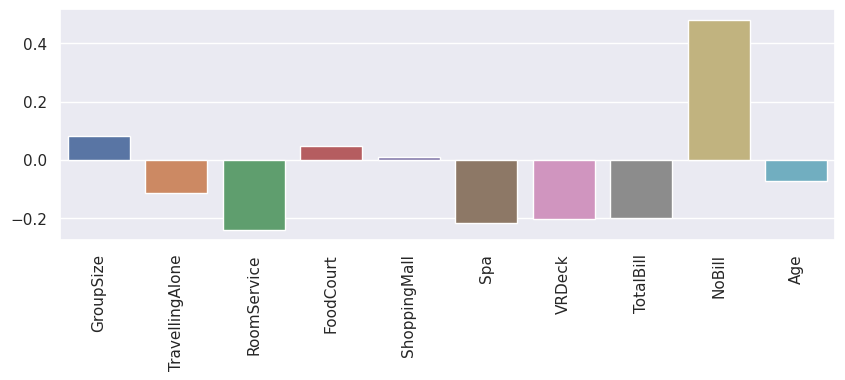

In [18]:
sns.set(style="darkgrid")
plt.figure(figsize = (10, 3))
plt.xticks(rotation = 90)
corr_series = graphing_data.corr(numeric_only = True)['Transported'].drop('Transported')
sns.barplot(x = corr_series.index, y = corr_series.values)
plt.show()

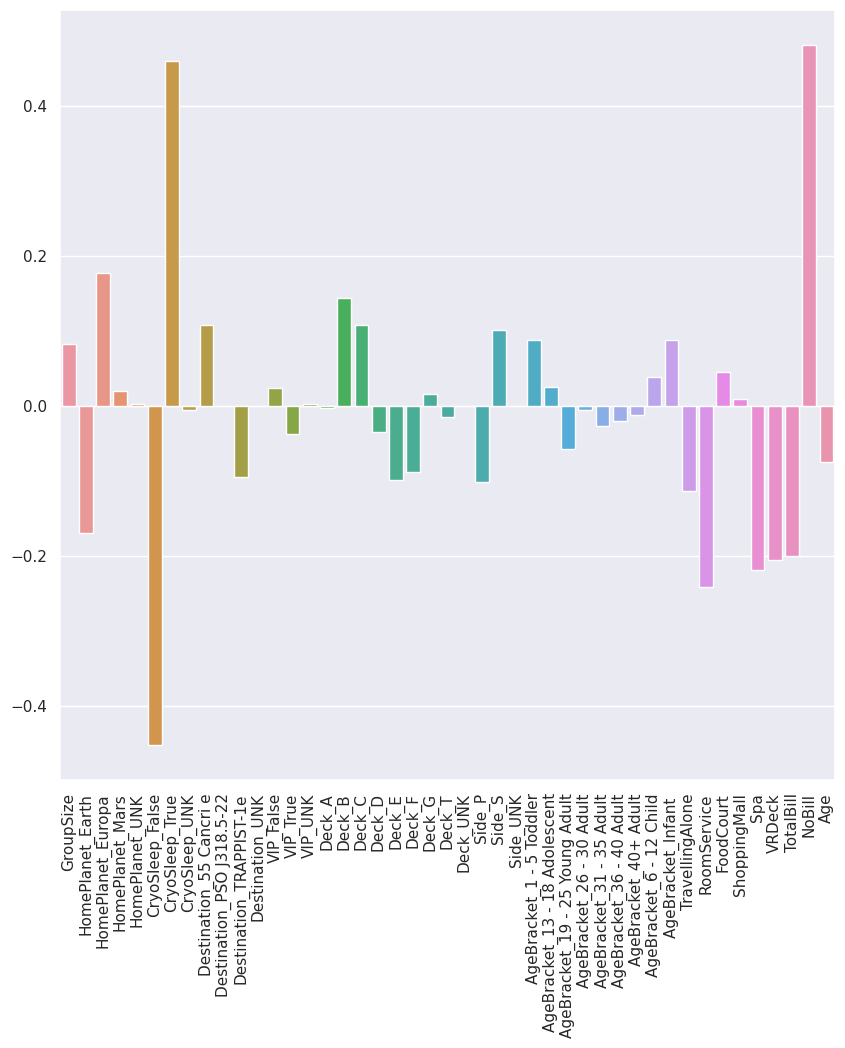

In [19]:
corrtest = preprocessor.fit_transform(raw_train_data)
sns.set(style="darkgrid")
plt.figure(figsize = (10, 10))
plt.xticks(rotation = 90)
corr_series = corrtest.corr(numeric_only = True)['Transported'].drop('Transported')
sns.barplot(x = corr_series.index, y = corr_series.values)
plt.show()

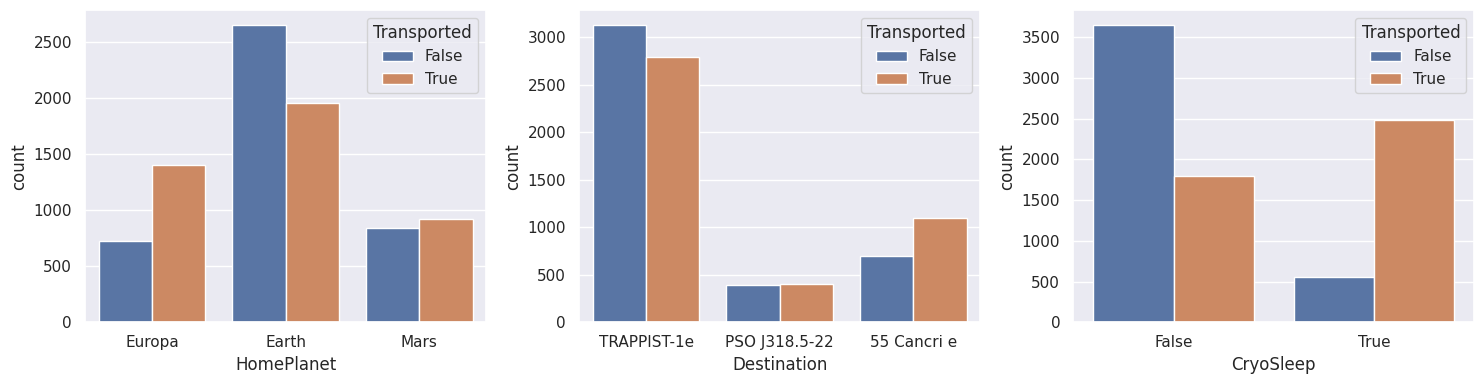

In [20]:
fig=plt.figure(figsize=(15,4))

columns = ['HomePlanet', 'Destination', 'CryoSleep']

for i in range(3):
    plt.subplot(1,3,i+1)
    sns.countplot(data = graphing_data, x = columns[i], hue = 'Transported')
    
fig.tight_layout()
plt.show()

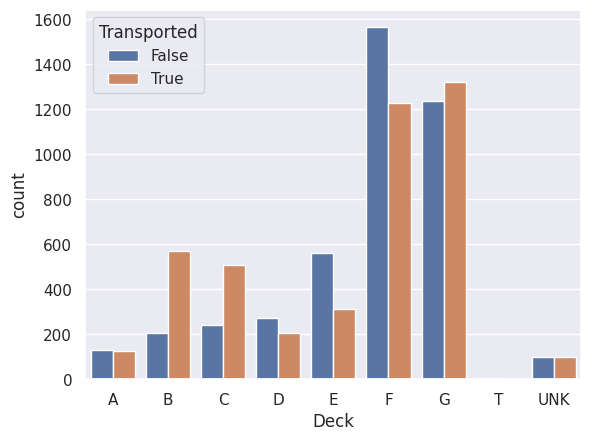

In [21]:
sns.countplot(data = graphing_data, x = 'Deck', hue = 'Transported', order=sorted(list(graphing_data['Deck'].unique())))
plt.show()

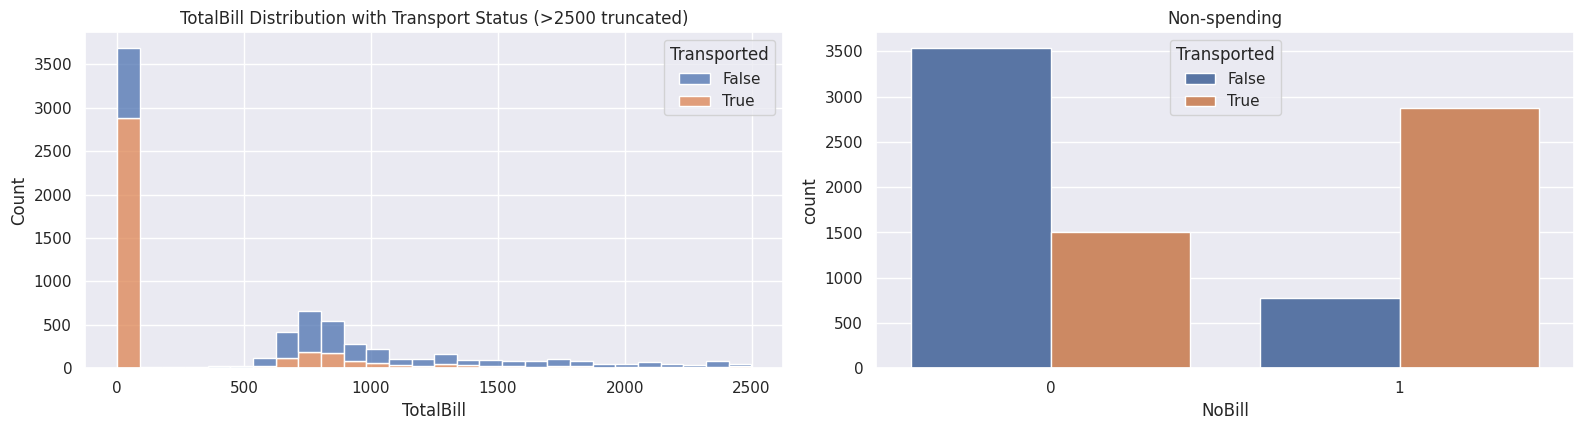

In [22]:
fig=plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
#sns.countplot(data = graphing_data, x = 'Deck', hue = 'Transported', order=sorted(list(graphing_data['Deck'].unique())))
plt.title('TotalBill Distribution with Transport Status (>2500 truncated)')
sns.histplot(data = graphing_data.loc[graphing_data['TotalBill'] < 2500], x = 'TotalBill', hue = 'Transported', multiple = 'stack')#, kde = True)
#plt.xlim([-50, 2500])

plt.subplot(2,2,2)
sns.countplot(data = graphing_data, x = 'NoBill', hue = 'Transported')
plt.title('Non-spending')
fig.tight_layout()

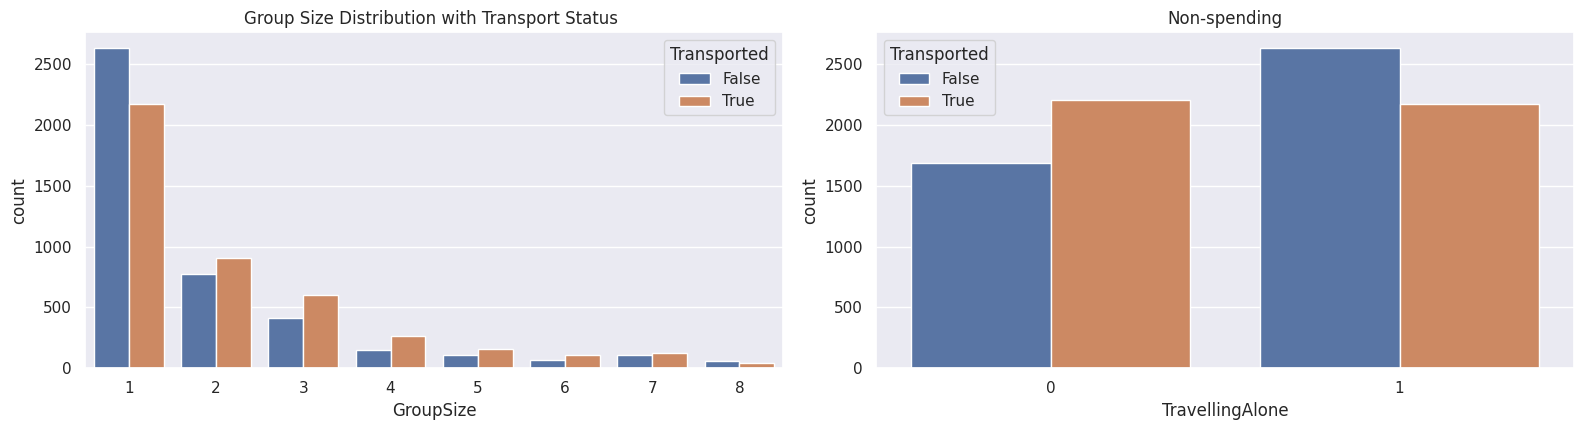

In [23]:
fig=plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
#sns.countplot(data = graphing_data, x = 'Deck', hue = 'Transported', order=sorted(list(graphing_data['Deck'].unique())))
plt.title('Group Size Distribution with Transport Status ')
sns.countplot(data = graphing_data, x = 'GroupSize', hue = 'Transported')#, multiple = 'stack')#, kde = True)
#plt.xlim([-50, 2500])

plt.subplot(2,2,2)
sns.countplot(data = graphing_data, x = 'TravellingAlone', hue = 'Transported')
plt.title('Non-spending')
fig.tight_layout()

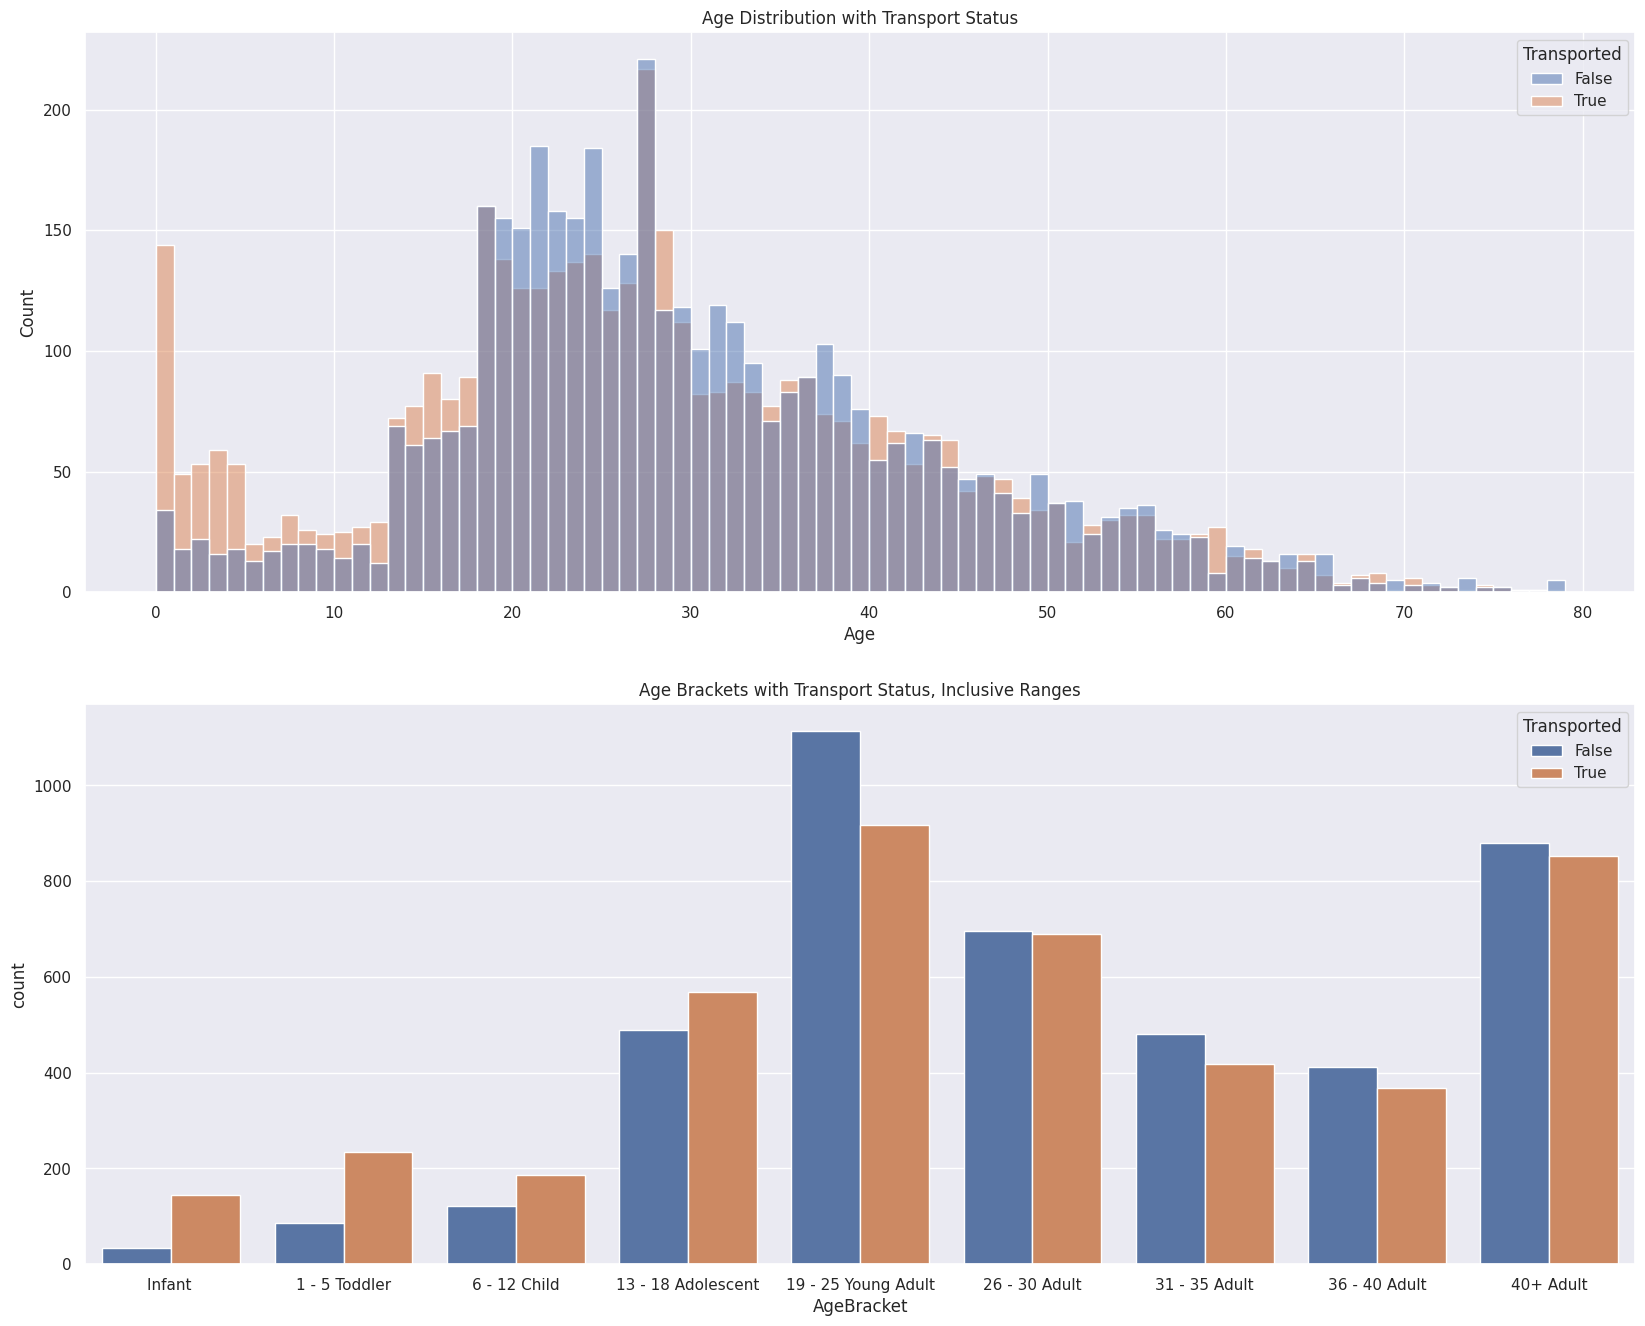

In [24]:
fig=plt.figure(figsize=(20,16))
plt.subplot(2,1,1)
plt.title('Age Distribution with Transport Status')
sns.histplot(data = graphing_data, x = 'Age', hue = 'Transported', binwidth = 1)#, multiple = 'stack')#, kde = True)
#plt.xlim([0, 40])

plt.subplot(2,1,2)
sns.countplot(data = graphing_data, x = 'AgeBracket', hue = 'Transported', order = bracket_names)#sorted(list(graphing_data['AgeBracket'].unique())))
#ordered_brackets = graphing_data[['AgeBracket', 'Transported']].copy()
#ordered_brackets['AgeBracket'] = pd.Categorical(graphing_data['AgeBracket'], [bracket[2] for bracket in brackets])
#sns.histplot(data = ordered_brackets, x = 'AgeBracket', hue = 'Transported')
plt.title('Age Brackets with Transport Status, Inclusive Ranges')
#plt.xticks(rotation = 90)
#fig.tight_layout()
plt.show()

# MODEL

In [25]:
import xgboost as xgb
import lightgbm as lgb

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_selection import SelectKBest, chi2

## GRIDSEARCH

In [27]:
y = raw_train_data['Transported']
X = raw_train_data.drop('Transported', axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
5623,5981_01,Mars,False,F/1140/S,TRAPPIST-1e,27.0,False,441.0,0.0,397.0,471.0,0.0,Harz Quart
5253,5606_01,Europa,True,B/213/S,55 Cancri e,45.0,False,0.0,0.0,0.0,0.0,0.0,Algor Paterpad
478,0515_01,Europa,True,B/20/S,TRAPPIST-1e,50.0,False,0.0,0.0,0.0,0.0,0.0,Alramix Swinvul
1352,1425_02,Earth,True,G/220/P,TRAPPIST-1e,1.0,False,0.0,0.0,0.0,0.0,0.0,Mael Adavisons
5344,5713_01,Earth,False,G/915/P,TRAPPIST-1e,42.0,False,0.0,29.0,317.0,434.0,45.0,Lawren Blangibson


In [28]:
'''
k_best = SelectKBest(chi2, k=20)
#clf = RandomForestClassifier(n_jobs = -1, random_state = 42, n_estimators = 100, max_depth = 13)
#gb_model = xgb.XGBClassifier(n_estimators=1250, learning_rate=0.005, n_jobs=8)#, early_stopping_rounds = 10)
clf = lgb.LGBMClassifier(objective = 'binary', n_jobs = -1, verbosity = -1)

full_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('kbest', k_best),
    ('model', clf)
])

k_vals = [22]#['all'] + list(range(20, 30+1, 2))

est_start = 590#575
est_end = 610#625
est_step = 1
n_estimators = list(range(est_start, est_end + 1, est_step))

n_estimators = [600]#, 1000]

depth_start = 14
depth_end = 20
depth_step = 1
max_depths = list(range(depth_start, depth_end + 1, depth_step))

max_depths = [14]

learning_rates  = [0.01]#[0.1, 0.05, 0.01]

#l1_reg = [None, 0.005, 0.001]
#l2_reg = [None, 0.005, 0.001]

#boost_types = ['gbdt', 'dart', 'rf'][:2]

drop_features = [
    {'dropIncl' : ['UNK', 'VIP']},
    {'dropIncl' : ['UNK', 'VIP', 'TotalBill']}
]

params = [
    {'model__n_estimators' : n_estimators,
     'model__learning_rate' : learning_rates,
     'model__max_depth' : max_depths,
     #'model__reg_alpha' : l1_reg,
     #'model__reg_lambda' : l2_reg,
     #'model__boosting_type' : boost_types,
     #'preprocessor__drop__kw_args' : drop_features
     'kbest__k' : k_vals
    }
]
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42).split(X, y)
#gridsearch = GridSearchCV(full_pipeline, param_grid = params, refit = True, cv = cv, scoring = 'f1', verbose = 10)
gridsearch = GridSearchCV(full_pipeline, param_grid = params, refit = True, cv = cv, scoring = 'accuracy', verbose = 10)
#gridsearch.fit(X, y)
#gridsearch.best_params_
#gridsearch.best_score_
'''
print()

## Best GBDT Model

In [29]:
gb_clf = lgb.LGBMClassifier(objective = 'binary', n_jobs = -1, verbosity = -1, learning_rate = 0.01, n_estimators = 600, max_depth = 14)
k_best = SelectKBest(chi2, k=22)
gb_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('kbest', k_best),
    ('model', gb_clf)
])
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42).split(X, y)
cv_score = cross_val_score(gb_pipeline, X, y, cv = cv, scoring = 'accuracy')
#cv_score
sum(cv_score)/len(cv_score)

0.8076607788161787

### Another GridSearch but for DART only this time

In [30]:
'''
clf_dart = lgb.LGBMClassifier(objective = 'binary', n_jobs = -1, verbosity = -1, boost_type = 'dart')

dart_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('kbest', k_best),
    ('model', clf_dart)
])

k_vals = [20]#list(range(15, 21+1, 1))# + ['all'] 
est_start = 975#920#875#575
est_end = 985#990#625
est_step = 1
n_estimators = list(range(est_start, est_end + 1, est_step))
n_estimators = [977]#, 980]#[700, 800, 850, 900]#, 1000]
depth_start = 5
depth_end = 15
depth_step = 1
max_depths = list(range(depth_start, depth_end + 1, depth_step))
max_depths = [9]#6,7,8,9]#None, 10, 20, 30]

learning_rates  = [0.01]#, 0.005]#0.1, 0.05, 0.01]

l1_reg = [None, 0.1, 0.05, 0.01]
l2_reg = [None, 0.1, 0.05, 0.01]

dart_params = [
    {'model__n_estimators' : n_estimators,
     'model__learning_rate' : learning_rates,
     'model__max_depth' : max_depths,
     #'model__reg_alpha' : l1_reg,
     #'model__reg_lambda' : l2_reg,
     'kbest__k' : k_vals
    }
]

cv_dart = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42).split(X, y)
#gridsearch = GridSearchCV(full_pipeline, param_grid = params, refit = True, cv = cv, scoring = 'f1', verbose = 2)
dart_search = GridSearchCV(dart_pipeline, param_grid = dart_params, refit = True, cv = cv_dart, scoring = 'accuracy', verbose = 10)
#dart_search.fit(X, y)
#dart_search.best_params_
#dart_search.best_score_
'''
print()

## Best DART Model
* However not much better in cv score and lower accuracy in actual test set

In [31]:
#This version overfit a little when submitted, as it had better cv accuracy of ~0.809 but submission was ~0.797 accuracy
k_best = SelectKBest(chi2, k=20)
dart_clf = lgb.LGBMClassifier(objective = 'binary', n_jobs = -1, verbosity = -1, max_depth = 9, boost_type = 'dart', learning_rate = 0.01, n_estimators = 977)#925)
dart_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('kbest', k_best),
    ('model', dart_clf)
])
cv = StratifiedKFold(n_splits = 5, shuffle=True, random_state = 42).split(X, y)
cv_score = cross_val_score(dart_pipeline, X, y, cv = cv, scoring = 'accuracy')
#cv_score
sum(cv_score)/len(cv_score)

0.8090405514590809

# Final Model
* Pipeline:
    * Preprocessor
    * KBest with chi2 score and best 22 features
    * Gradient booster with:
        * Boost type GBDT
        * Learning rate of 0.01
        * 600 estimators
        * Max depth of 14

In [32]:
k_best = SelectKBest(chi2, k=22)
final_clf = lgb.LGBMClassifier(objective = 'binary', n_jobs = -1, verbosity = -1, max_depth = 14, boost_type = 'gbdt', learning_rate = 0.01, n_estimators = 600)
final_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('kbest', k_best),
    ('model', final_clf)
])
final_pipeline.fit(X,y)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('preprocessor_0',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('unpack',
                                                                   Pipeline(steps=[('unpacker',
                                                                                    FunctionTransformer(func=<function Unpacker at 0x787975486710>)),
                                                                                   ('imputer',
                                                                                    SimpleImputer(fill_value='UNK',
                                                                                                  strategy='constant')),
                                                                                   ('group_size_calc',
                                                                                    FunctionTransformer(func=<function GroupSizeCa...
                                                                    'Destination',
                                                                    'VIP',
                                                                    'Deck',
                                                                    'Side',
                                                                    'AgeBracket'])],
                                                    verbose_feature_names_out=False)),
                                 ('drop',
                                  FunctionTransformer(func=<function dropFunc at 0x787975487b50>))])),
                ('kbest',
                 SelectKBest(k=22,
                             score_func=<function chi2 at 0x78796eb15630>)),
                ('model',
                 LGBMClassifier(boost_type='gbdt', learning_rate=0.01,
                                max_depth=14, n_estimators=600, n_jobs=-1,
                                objective='binary', verbosity=-1))])

## Predictions and Output

In [33]:
X_test = raw_test_data
predictions = final_pipeline.predict(X_test)
output = pd.concat([X_test['PassengerId'], pd.DataFrame(predictions, columns = ['Transported'])], axis = 1)
output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [34]:
output.to_csv('output.csv', index = False)